In [1]:
import xarray as xr
import numpy as np

import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import matplotlib.pyplot as plt

# Introduction

Unfortunately, I have just discovered that teh *ExtremeWeather* dataset is not from real observations, but is indeed a simulation, from the CAM5 model. Indeed, it is very similar to the other simulation data I have downloaded, which is also from the CAM data.

I thus test some new data, which I have found on the [Physical Society Webpage](https://psl.noaa.gov/cgi-bin/db_search/DBListFiles.pl?did=195&tid=92225&vid=31). I should have found the U850, so let's see if something can be done with it.

# Data Exploration

In [2]:
# load actual real data
real_data = xr.load_dataset("./data.nosync/uwnd.sig995.2005.nc")

A simple plot

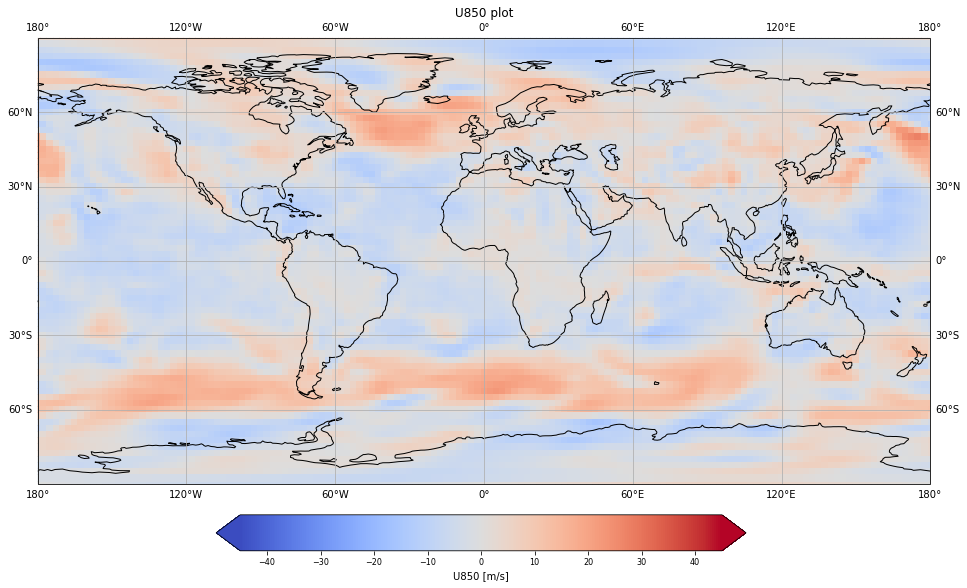

In [3]:
# We already tried pcolormesh (Module 1)

fig = plt.figure(figsize=(16, 10))  # x,y(inches)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("U850 plot")
ax.set_global()
mm = ax.pcolormesh(real_data.lon,
                   real_data.lat,
                   real_data.uwnd[0, :, :],
                   transform=ccrs.PlateCarree(),
                   cmap=mpl.cm.coolwarm,
                   vmin=-45,
                   vmax=45)

ax.coastlines()
ax.gridlines(draw_labels=True)

#- add colorbar
cbar_ax = fig.add_axes([0.28, 0.10, 0.46,
                        0.05])  #[left, bottom, width, height]
cbar = fig.colorbar(mm, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('U850 [m/s]')
cbar.ax.tick_params(labelsize=8)
plt.show()
plt.close()

Okay, we have something. Unfortunately, there are some problems: the data has very low resolution. I do not belive that this resolution might allow to distinguish very small cyclones, but just the big ones. Thus, its use is most likely limited.

**NB**: I have requested higher quality images, from the Copernicus satellite, but I have to see.

Yearly-average plot

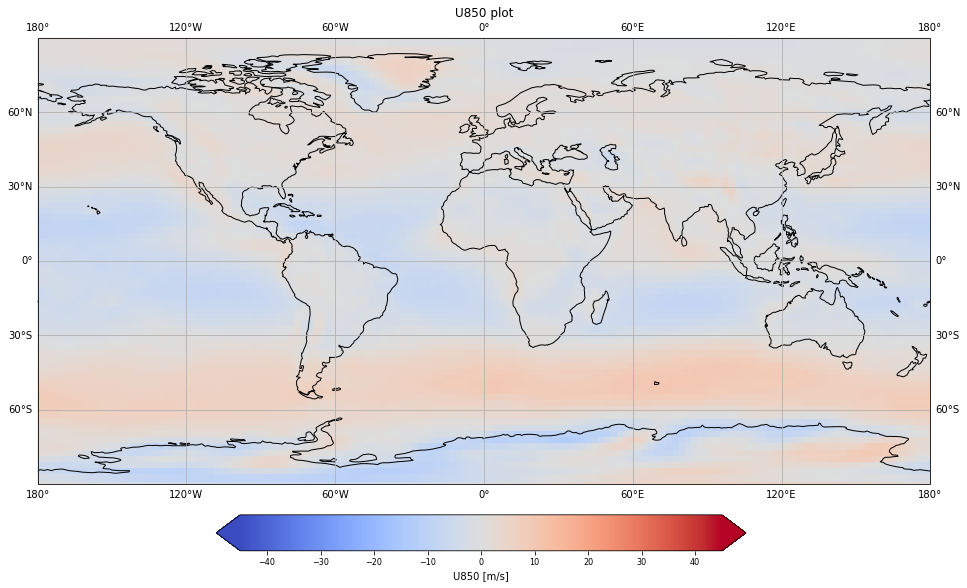

In [4]:
# We already tried pcolormesh (Module 1)

fig = plt.figure(figsize=(16, 10))  # x,y(inches)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("U850 plot")
ax.set_global()
mm = ax.pcolormesh(real_data.lon,
                   real_data.lat,
                   real_data.uwnd[:, :, :].mean(axis=0),
                   transform=ccrs.PlateCarree(),
                   cmap=mpl.cm.coolwarm,
                   vmin=-45,
                   vmax=45)

ax.coastlines()
ax.gridlines(draw_labels=True)

#- add colorbar
cbar_ax = fig.add_axes([0.28, 0.10, 0.46,
                        0.05])  #[left, bottom, width, height]
cbar = fig.colorbar(mm, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('U850 [m/s]')
cbar.ax.tick_params(labelsize=8)
plt.show()
plt.close()

The results look very similar to the simulated data: this is very positive. I shall try to use the confrontation script to see if I get some cyclons or not.

# Classifier Confrontation

Due to how the script was implemented, this new "actually" real data shall be called fake, while the simulated data (from the [ExtremeWeather dataset](https://extremeweatherdataset.github.io)) is called "real".

In [5]:
import numpy as np
# import netCDF4 as nc
import xarray as xr
import h5py
import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
import seaborn as sns
import matplotlib as mpl
import cv2
from datetime import datetime

# from sklearn.metrics import roc_curve

from tensorflow.keras.models import load_model, Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Input, Concatenate

# this way I do not have to reshape the data
from keras.backend import set_image_data_format, image_data_format
from tensorflow.compat.v1 import disable_eager_execution
from tensorflow import executing_eagerly
from tensorflow.python.compiler.mlcompute import mlcompute

# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

set_image_data_format('channels_first')
assert image_data_format(
) == 'channels_first', "Plase set keras backend as channels first."

# APPLE SPECIFIC IMPLEMENTATION
disable_eager_execution()
assert executing_eagerly(
) is False, "Please do not set to eager execution for this program."

# Import mlcompute module to use the optional set_mlc_device API for device selection with ML Compute.
mlcompute.set_mlc_device(
    device_name='cpu')  # Available options are 'cpu', 'gpu', and 'any'.

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

# select how many examples to be tested
HOW_MANY = 20
# (WARNING) due to some code problems, with too high
# numbers you may need to run multiple times in order
# not to have it crash

# FAKE DATA
print("Load fake data")
datapath = "./data.nosync/uwnd.sig995.2005.nc"
dataset = xr.load_dataset(datapath)
# this data is already only for 2005
# the shape is (time, lat, lon)

lon_model = sorted(dataset.lon.values)
lat_model = sorted(dataset.lat.values)

# REAL DATA
print("Load real data")
# this data is alreay geo-reference and prepared with the cyclon boxes
# through other scripts
hf = h5py.File("./data.nosync/georeferenced_pos.h5", 'r')

# select the dates for the period 2005
# print('Prepare fake dates')
# date_period_interest = dataset['date'][(dataset['date'][:] > 20041231)
#                                        & (dataset['date'][:] < 20060101)]
# just have consistency accross date formats
date_fake = [
    date.astype(datetime).date()
    for date in dataset.time[()].values[()].astype("<M8[us]")
]

print("Prepare real dates")
date_real = hf['time'][()].astype("<M8[us]")
date_real = [date.astype(datetime).date() for date in date_real]

print("Select %i random real cyclons." % HOW_MANY)
# select some random indexes
idx_cyclons = sorted(
    np.random.uniform(0, len(date_real), HOW_MANY).astype(int))
# select date and cyclon image from the real data
real_images = hf['images'][idx_cyclons]
date_real = np.array(date_real)[idx_cyclons]

print("Find corresponding fake image.")
# i use the date to match the images
# (IMPORTANT) The real data as 4 images per day, while the simulated just one
# nonetheless, it will be matched by the day (so up to 4 real images might have 1
# simulated image)
# select index
idx_fake_cyclon = [
    np.where(np.array(date_fake) == dd)[0][0] for dd in date_real
]
# select image with index. Here the image is still the whole globe
fake_images = dataset.uwnd.values[idx_fake_cyclon]
# use lat and lon to figure out the box position
# (WARNING) since the lat and lon do not precisely coincide,
# some error, of up to 0.5, is allowed.
# If more lat or lon are available, just select the first one
print("Cut around cyclon in fake images")
fake_images = [
    fake_image[np.where(np.isclose(lat_model, lat_min, atol=5))[0][0]:np.
               where(np.isclose(lat_model, lat_max, atol=5))[0][0],
               np.where(np.isclose(lon_model, lon_min, atol=5))[0][0]:np.
               where(np.isclose(lon_model, lon_max, atol=5))[0][0]]
    for fake_image, lat_min, lat_max, lon_min, lon_max in zip(
        fake_images, hf['lat_min'][idx_cyclons], hf['lat_max'][idx_cyclons],
        hf['lon_min'][idx_cyclons], hf['lon_max'][idx_cyclons])
]
# (NOTICE) i dati sono già ordinati
# since the simulated images have all different sizes, scale up
# to the train size (120, 120)

print("Remove bad selections")
good_idx = [
    idx for idx, im in enumerate(fake_images)
    if not (im.shape[1] == 0 or im.shape[0] == 0)
]
# do the transpose, since "real_images" is (lon, lat), but "fake_images" is (lat, lon)
fake_images = [
    np.transpose(el) for i, el in enumerate(fake_images) if i in good_idx
]
real_images = np.array(
    [el for i, el in enumerate(real_images) if i in good_idx])

Load fake data
Load real data
Prepare real dates
Select 20 random real cyclons.
Find corresponding fake image.
Cut around cyclon in fake images
Remove bad selections


In [6]:
print('Resize to correct size')
fake_images = [
    cv2.resize(np.transpose(fake_image),
               dsize=(120, 120),
               interpolation=cv2.INTER_CUBIC) for fake_image in fake_images
]
fake_images = np.stack(fake_images, axis=0)
# the rea images have 3 channels, but the simulated ones just the U850
print('Consider only U850 channel in real images')
real_images = real_images[:, [0], :, :]
# for the neural net, I need the channel dimension
fake_images = np.expand_dims(fake_images, axis=1)
# just a small check
assert fake_images.shape == real_images.shape, 'Some mistake in the definition of the arrays'

# this few layer ahead are needed, since the VGG16 classifier takes only 3 channel images
# (I just take 3 identical channels)
print("Loading VGG (with concatenation of the single channel)")
new_input = Input(shape=fake_images.shape[1:])
img_conc = Concatenate(axis=1)([new_input, new_input, new_input])
VGG_model = VGG16(include_top=False, input_tensor=img_conc)
base_model = Model(inputs=VGG_model.input, outputs=VGG_model.layers[15].output)

# the model is loaded. This is the part trained locally
print("Load pre-trained CNN classifier for cyclons (U850 specific)")
U850_model = load_model("./trained_models/model_just_850_4")

print(
    "Since the real data depicts all cyclons, we are sure the correct class to be '1'."
)
print("Let's see a (very) bias accuracy")
print("ACC: %.3f" % (U850_model.evaluate(base_model.predict(real_images),
                                         np.zeros(len(real_images)) + 1)[-1]))

print("Let's select the cyclons the classifier manages to classify correctly.")
correct_idx = np.where((U850_model.predict(base_model.predict(real_images)) +
                        0.5).astype(int) == 1)[0]

print("Accuracy on fake data %.3f" %
      (U850_model.evaluate(base_model.predict(fake_images[correct_idx]),
                           np.zeros(len(correct_idx)) + 1)[-1]))

print("""[COMMENT] The low accuracy score 
        on the real images can mostly 
        be due to the incapacity of 
        the generative model, and 
        not my classifier, which on 
        simulated data (train) predict correctly 
        the presence of a cyclon in 
        the same region.""")

Resize to correct size
Consider only U850 channel in real images
Loading VGG (with concatenation of the single channel)
Load pre-trained CNN classifier for cyclons (U850 specific)
Since the real data depicts all cyclons, we are sure the correct class to be '1'.
Let's see a (very) bias accuracy


/Users/leonardoalchieri/anaconda3/envs/tf_apple_2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


ACC: 0.900
Let's select the cyclons the classifier manages to classify correctly.
Accuracy on fake data 0.056
[COMMENT] The low accuracy score 
        on the real images can mostly 
        be due to the incapacity of 
        the generative model, and 
        not my classifier, which on 
        simulated data (train) predict correctly 
        the presence of a cyclon in 
        the same region.


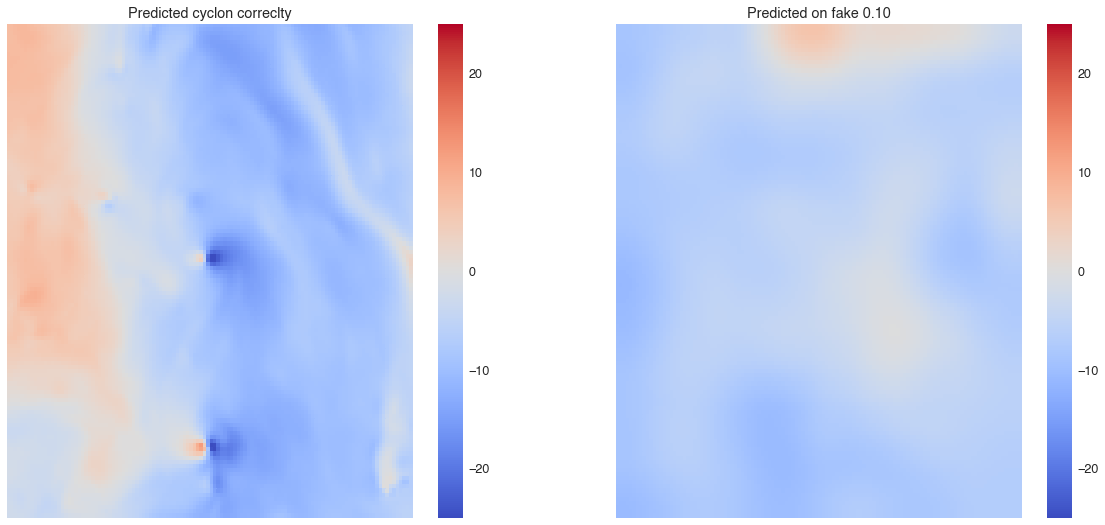

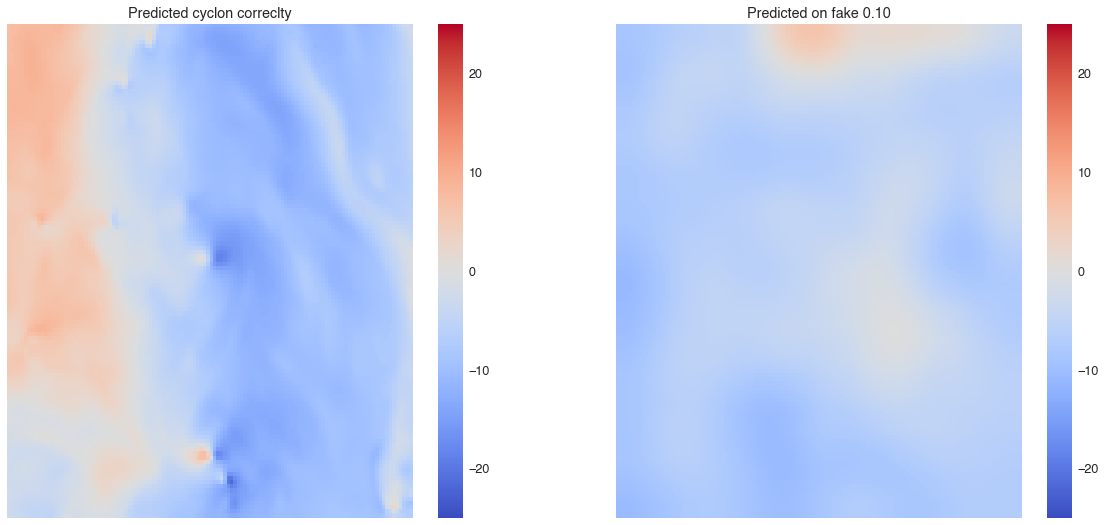

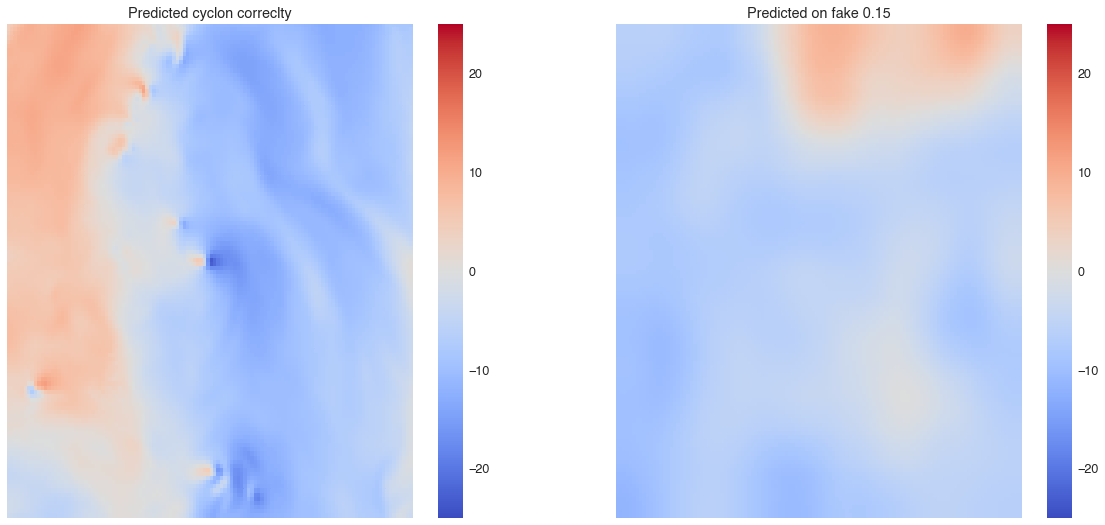

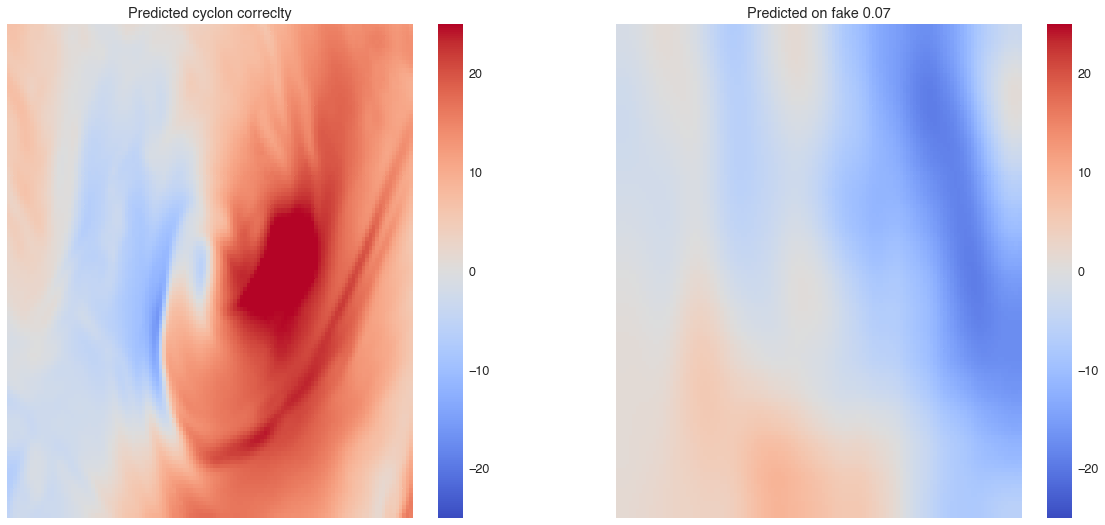

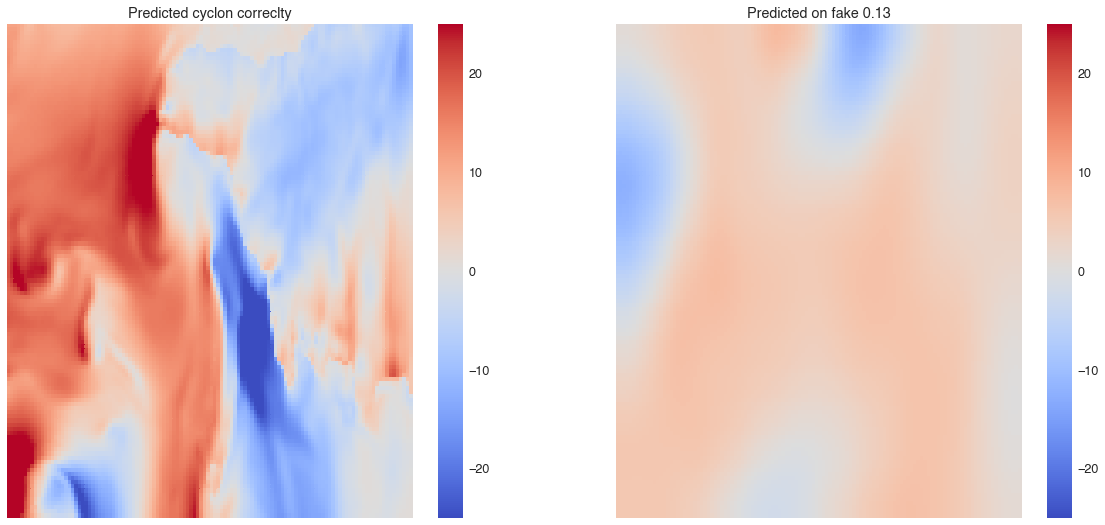

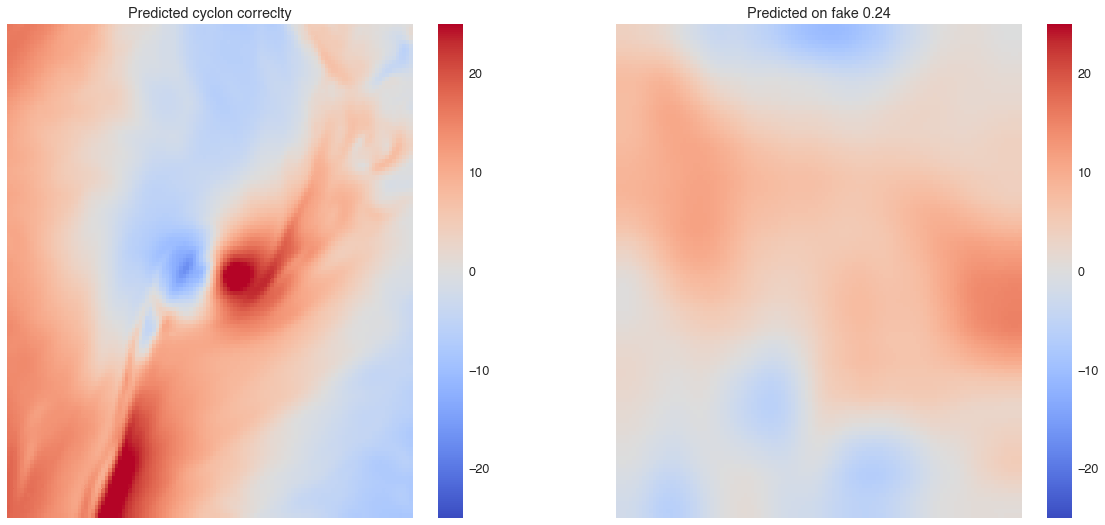

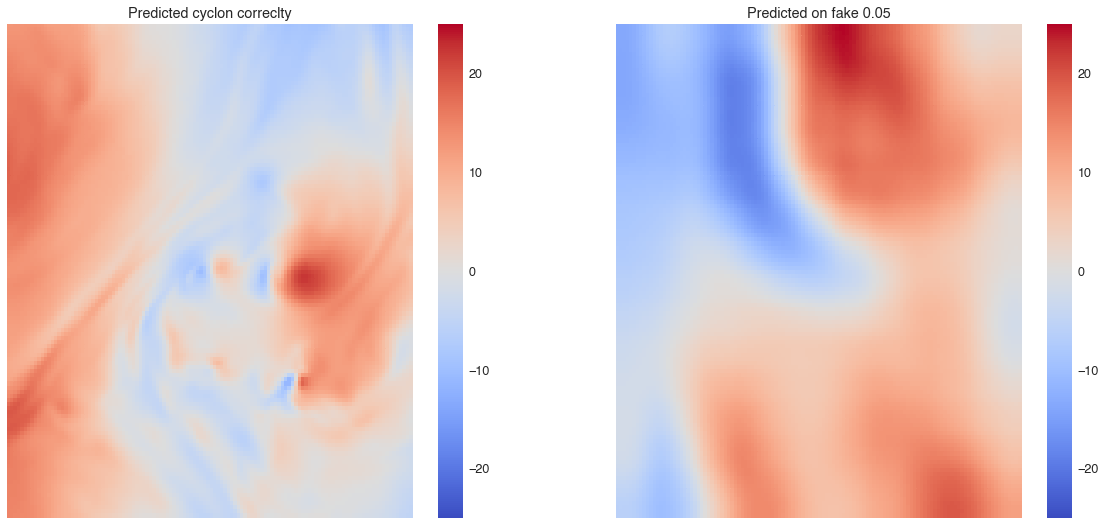

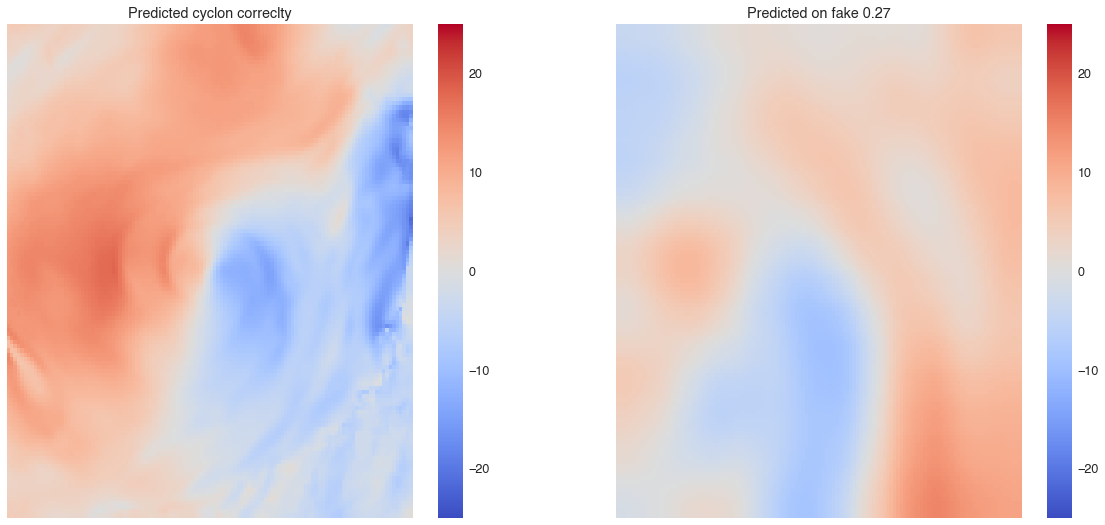

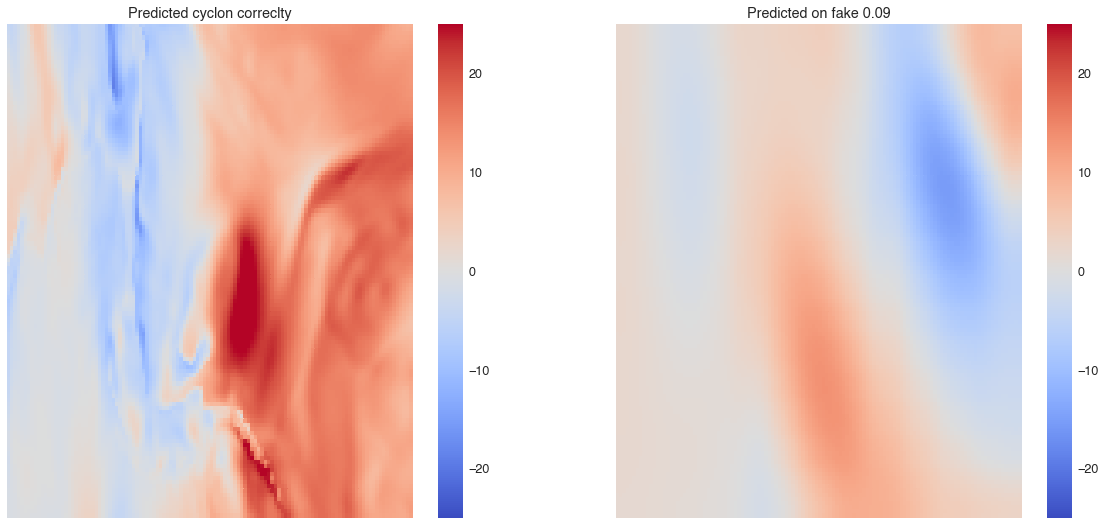

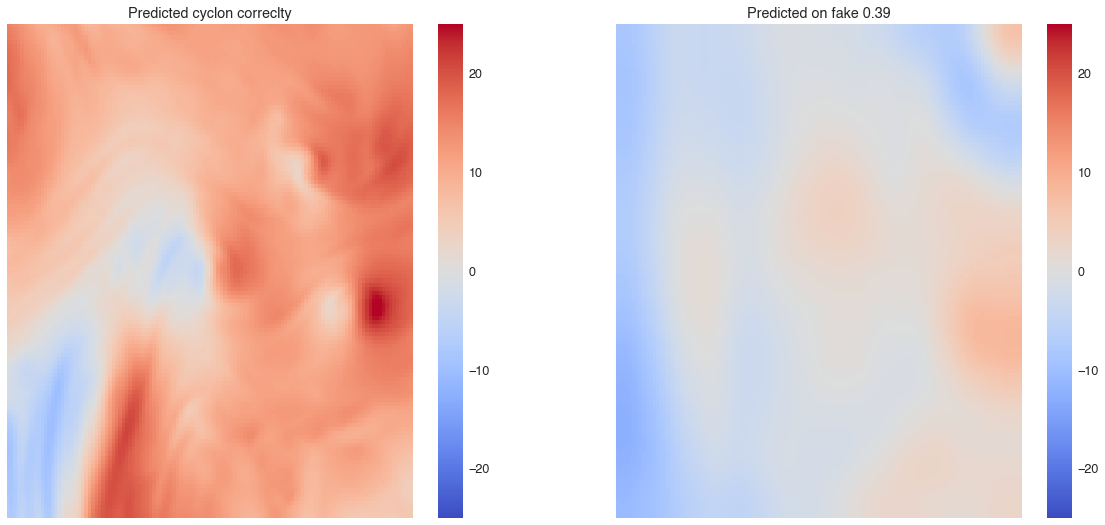

In [7]:
# plot just the first 10
for i, idx in enumerate(correct_idx):
    if i == 10:
        break
    plt.figure(figsize=(20, 20))
    plt.subplot(221)
    fig = sns.heatmap(np.transpose(real_images[idx, 0, :, :]),
                      vmin=-25,
                      vmax=25,
                      cmap=mpl.cm.coolwarm)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title("Predicted cyclon correclty")
    plt.subplot(222)
    fig = sns.heatmap(np.transpose(fake_images[idx, 0, :, :]),
                      vmin=-25,
                      vmax=25,
                      cmap=mpl.cm.coolwarm)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

    plt.title(
        "Predicted on fake %.2f" %
        (U850_model.predict(base_model.predict(fake_images[[idx], :, :, :]))))
    plt.show()

This result could show two main things:
- The inhability of the simulated data to correctly recreate actual hurricanes. In this scenario, the very low accuracy on positive samples (cyclons) on the satellite data would can be seen as the actual non-presence of cyclons in the selected region.
- The inability of the classifier to correctly predict when a lower image resolution (or scaled resolution, as is being used). In this case, we would consider that the simulation has the ability to reproduce correctly the time and location of the actual cyclons, and that the too low resolution of the satellite data does not allow to distinguish them, even through manual validation.

Obviously, the real reason is very difficult to discern without the use of other datasets, and could also a combionation of the two hypothesis presented. Nonetheless, the results are lukewarm and further investigation on this front is surely needed.

**Small note**: the reason the model struggles so much on the "real data" may be due to their value ranges: the real data, mostly due to its lower resolution, tends to have much lower values. 

In the following script, I try to overcome a little bit this problem, by rescaling the "real data" to the mean of the simulated one.

### Small rescaling

In [10]:
print("*** CLASSIFIER WITH RESCALED-REAL ***")
fake_images = (fake_images - np.mean(
    fake_images, axis=(0, 1, 2, 3))) + np.mean(real_images, axis=(0, 1, 2, 3))
# just a small check
assert fake_images.shape == real_images.shape, 'Some mistake in the definition of the arrays'

# this few layer ahead are needed, since the VGG16 classifier takes only 3 channel images
# (I just take 3 identical channels)
print("Loading VGG (with concatenation of the single channel)")
new_input = Input(shape=fake_images.shape[1:])
img_conc = Concatenate(axis=1)([new_input, new_input, new_input])
VGG_model = VGG16(include_top=False, input_tensor=img_conc)
base_model = Model(inputs=VGG_model.input, outputs=VGG_model.layers[15].output)

# the model is loaded. This is the part trained locally
print("Load pre-trained CNN classifier for cyclons (U850 specific)")
U850_model = load_model("./trained_models/model_just_850_4")

print(
    "Since the real data depicts all cyclons, we are sure the correct class to be '1'."
)
print("Let's see a (very) bias accuracy")
print("ACC: %.3f" % (U850_model.evaluate(base_model.predict(real_images),
                                         np.zeros(len(real_images)) + 1)[-1]))

print("Let's select the cyclons the classifier manages to classify correctly.")
correct_idx = np.where((U850_model.predict(base_model.predict(real_images)) +
                        0.5).astype(int) == 1)[0]

print("Accuracy on fake data %.3f" %
      (U850_model.evaluate(base_model.predict(fake_images[correct_idx]),
                           np.zeros(len(correct_idx)) + 1)[-1]))

print("""[COMMENT] The low accuracy score 
        on the real images can mostly 
        be due to the incapacity of 
        the generative model, and 
        not my classifier, which on 
        simulated data (train) predict correctly 
        the presence of a cyclon in 
        the same region.""")

*** CLASSIFIER WITH RESCALED-REAL ***
Loading VGG (with concatenation of the single channel)
Load pre-trained CNN classifier for cyclons (U850 specific)
Since the real data depicts all cyclons, we are sure the correct class to be '1'.
Let's see a (very) bias accuracy
ACC: 0.900
Let's select the cyclons the classifier manages to classify correctly.
Accuracy on fake data 0.000
[COMMENT] The low accuracy score 
        on the real images can mostly 
        be due to the incapacity of 
        the generative model, and 
        not my classifier, which on 
        simulated data (train) predict correctly 
        the presence of a cyclon in 
        the same region.


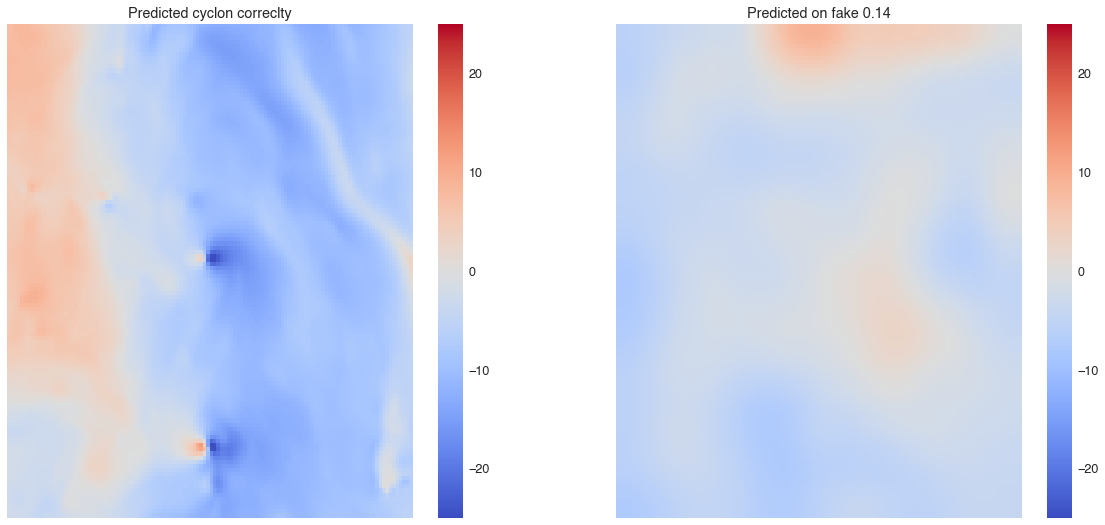

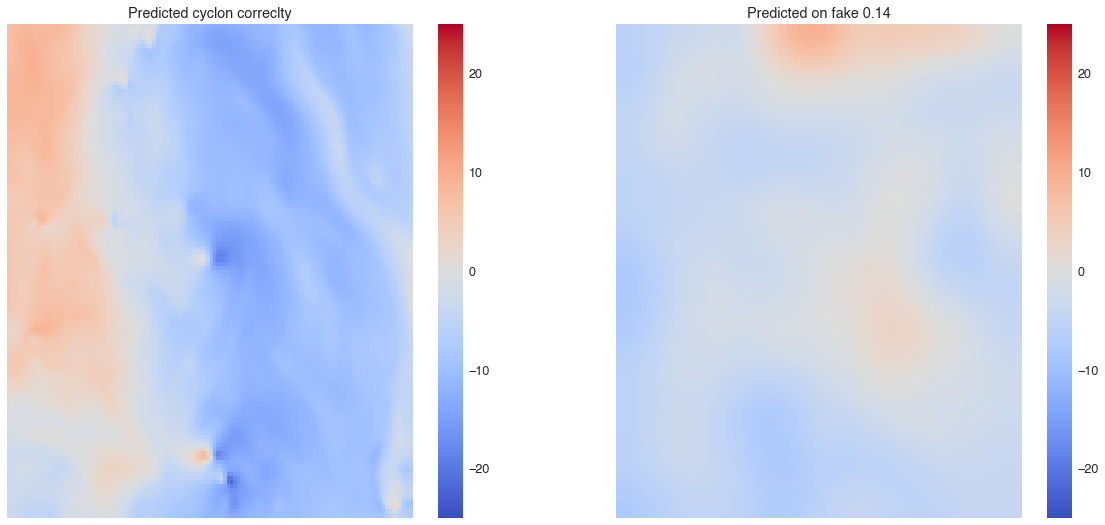

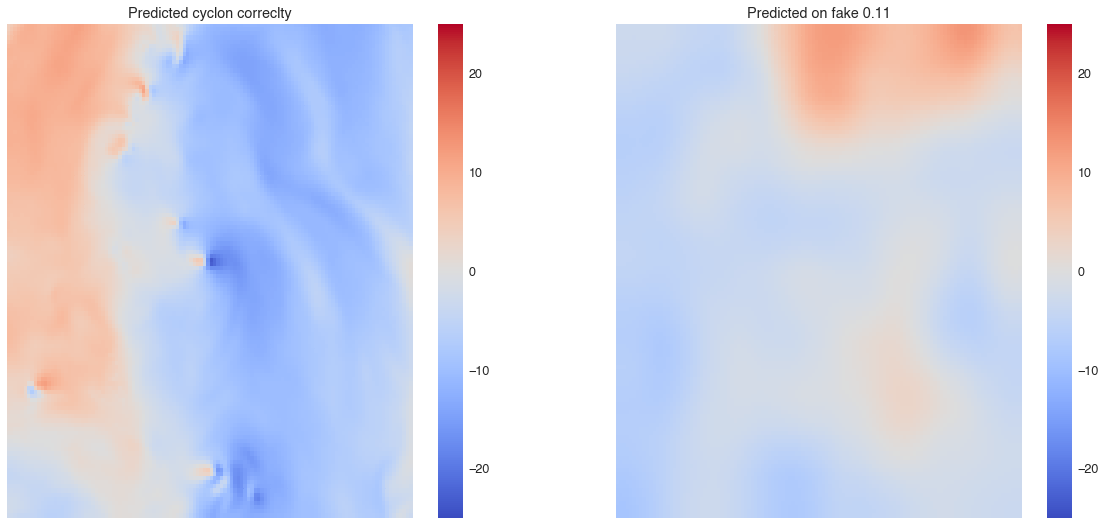

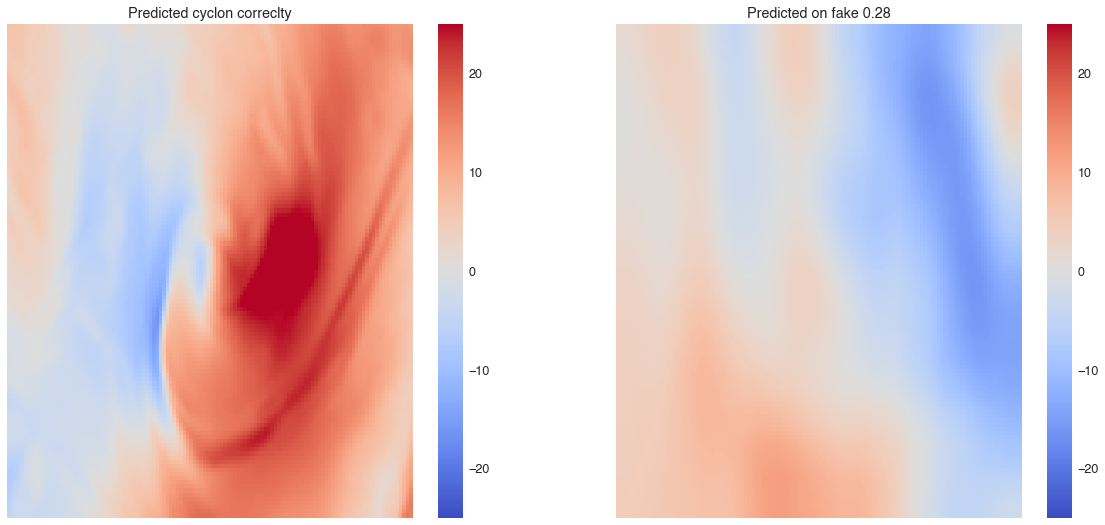

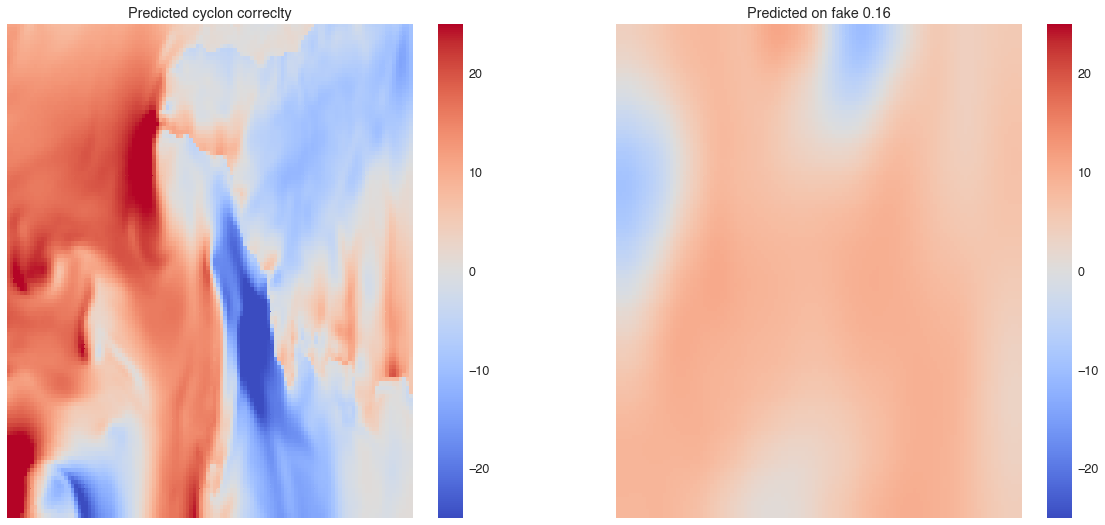

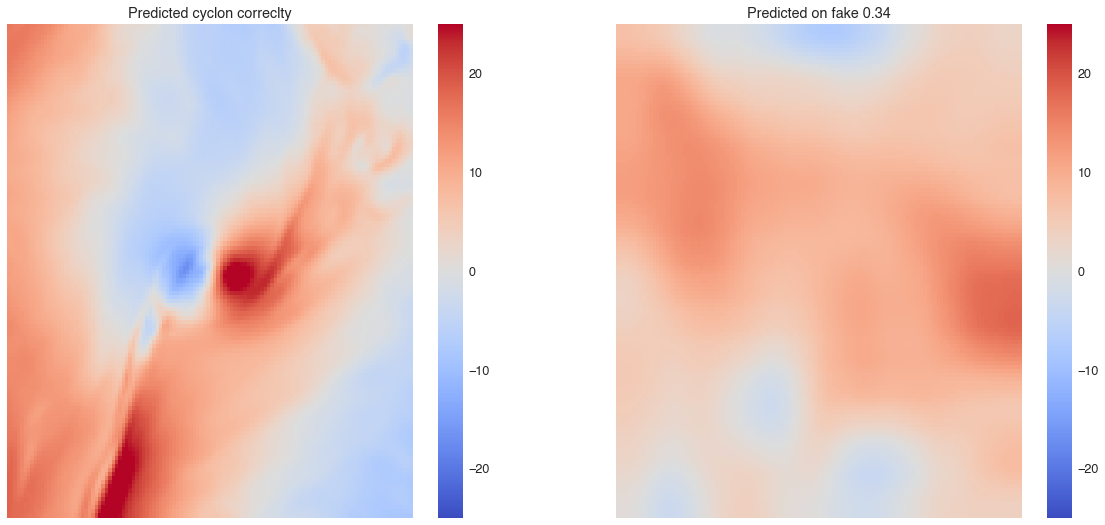

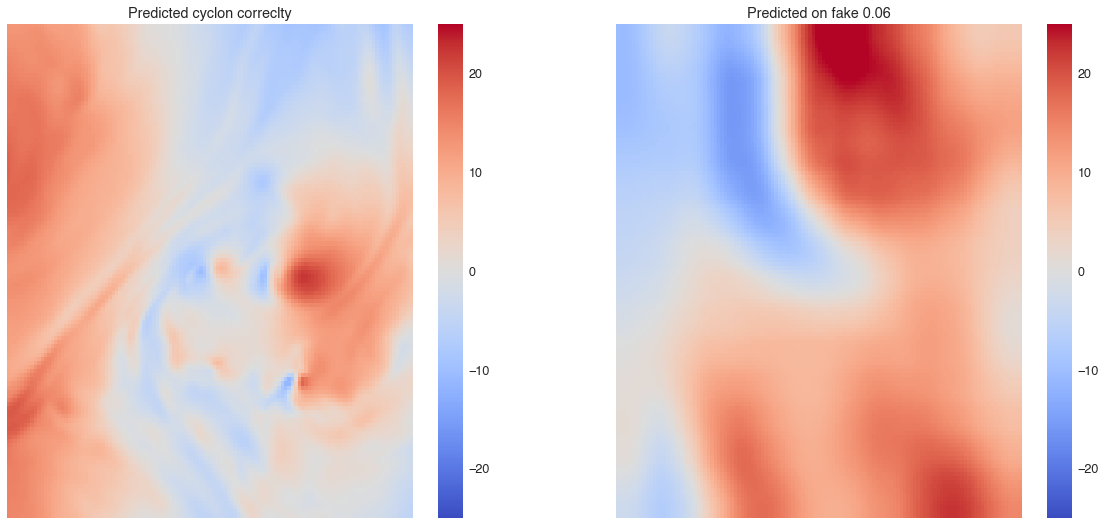

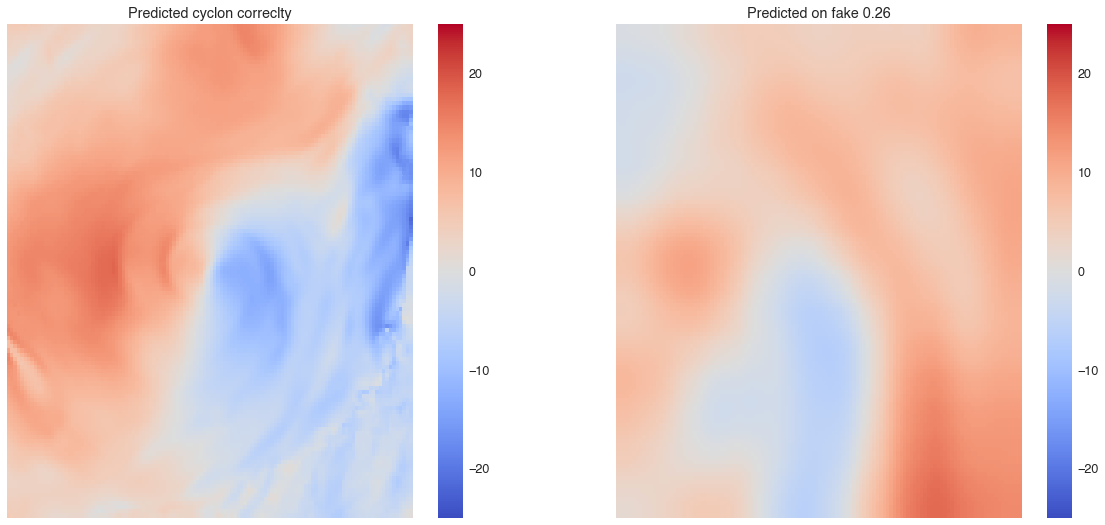

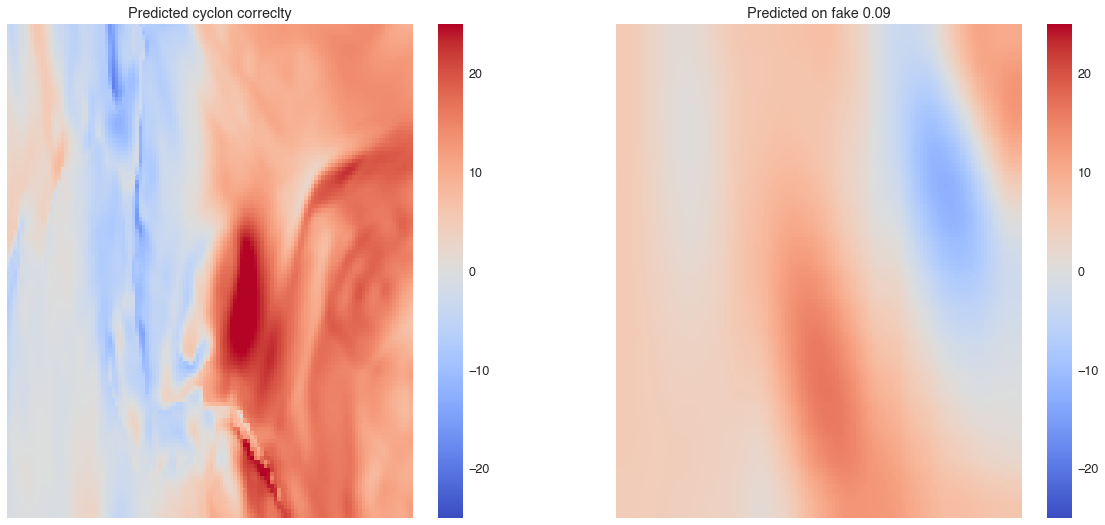

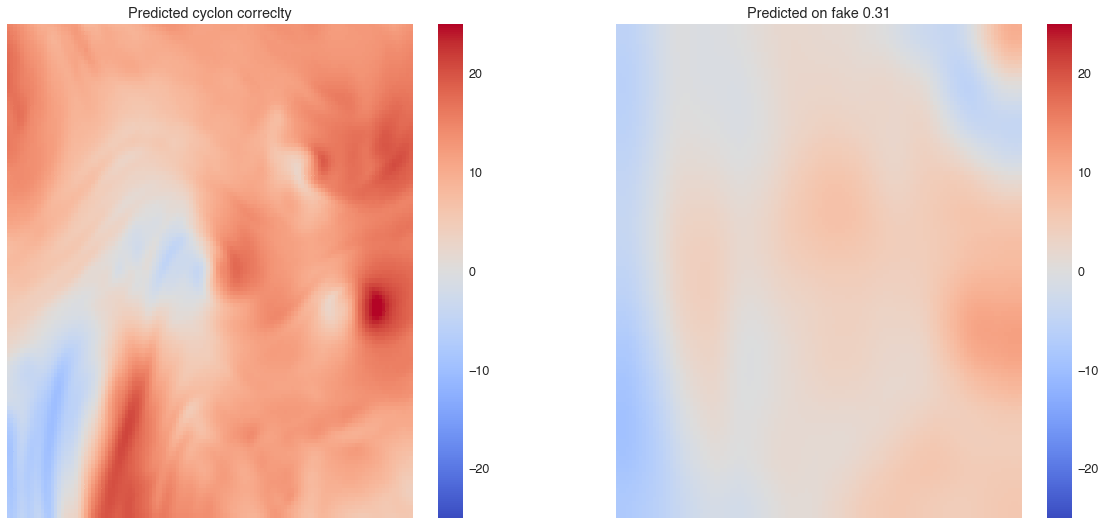

In [11]:
# plot just the first 10
for i, idx in enumerate(correct_idx):
    if i == 10:
        break
    plt.figure(figsize=(20, 20))
    plt.subplot(221)
    fig = sns.heatmap(np.transpose(real_images[idx, 0, :, :]),
                      vmin=-25,
                      vmax=25,
                      cmap=mpl.cm.coolwarm)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title("Predicted cyclon correclty")
    plt.subplot(222)
    fig = sns.heatmap(np.transpose(fake_images[idx, 0, :, :]),
                      vmin=-25,
                      vmax=25,
                      cmap=mpl.cm.coolwarm)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

    plt.title(
        "Predicted on fake %.2f" %
        (U850_model.predict(base_model.predict(fake_images[[idx], :, :, :]))))
    plt.show()

Once I try to rescale the data, it fails even more spectacularly: no cyclone is ever detected. Thus, I can assume that the problem was not on the data.